In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from aging.behavior.syllables import relabel_by_usage
from sklearn.cross_decomposition import PLSRegression
import colorcet as cc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import umap
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import r2_score

In [2]:
def age_map(string) -> int:
    '''returns age in weeks'''
    if '3m' in string:
        return 3 * 4
    if '6m' in string:
        return 6 * 4
    if '12m' in string:
        return 12 * 4
    if '18m' in string:
        return 18 * 4
    if '22m' in string:
        return 22 * 4
    if '3w' in string:
        return 3
    if '5w' in string:
        return 5
    if '7w' in string:
        return 7
    if '9w' in string:
        return 9

In [4]:
def load_df():
    df = pd.read_parquet('/Users/wingillis/db-hms/lab-datta/projects/ontogeny/data/parquet/ontogeny_males_syllable_df.parquet')
    df = relabel_by_usage(df, return_map=False)
    df['age'] = df['age'].map(age_map)

    usage_df = df.query('onsets').groupby(['age', 'subject_name', 'uuid'])['relabeled_syllables'].value_counts(normalize=True)
    usage_df.name = 'usage'
    usage_df = usage_df.reset_index()

    usage_mtx = usage_df.pivot_table(values='usage', columns='relabeled_syllables', index=['age', 'uuid']).fillna(0)
    return usage_mtx

In [5]:
usage_mtx = load_df()

In [93]:
um = usage_mtx.iloc[:, :]

In [94]:
mdl = PLSRegression(n_components=2)
mdl.fit(um, um.index.get_level_values('age'))

PLSRegression()

In [95]:
mdl.x_loadings_.shape

(63, 2)

In [96]:
projection = mdl.transform(um)

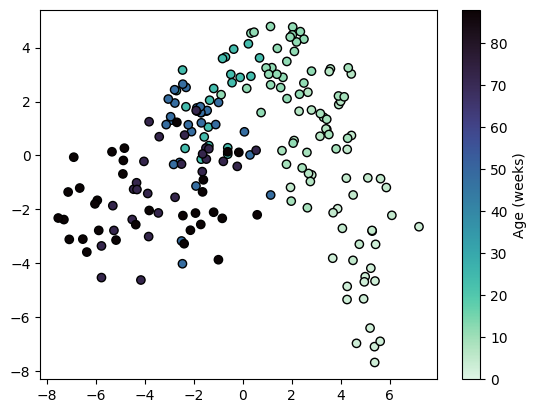

In [97]:
plt.scatter(projection[:, 0], projection[:, 1], c=um.index.get_level_values('age'), cmap='mako_r', lw=1, edgecolors='k', vmin=0)
plt.colorbar(label='Age (weeks)')

## Longtogeny

In [3]:
earliest_mouse_age = 21  # days

def age(df):
    return ((df['date'] - df['date'].min()).dt.days + earliest_mouse_age) / 7

def load_long_df():
    df = pd.read_parquet('/Users/wingillis/db-hms/lab-datta/projects/ontogeny/data/parquet/longtogeny_males_syllable_df.parquet')
    df = relabel_by_usage(df, return_map=False)
    df['mouse_id'] = df['subject_name'].str[:5]
    ages = df.groupby('mouse_id', sort=False).apply(age)
    df['age'] = ages.droplevel(0)

    session_length = df.groupby('uuid')['timestamps'].max()
    remove_uuids = session_length[session_length < 600].index
    df = df[~df['uuid'].isin(remove_uuids)]

    usage_df = df.query('onsets').groupby(['age', 'mouse_id', 'uuid'])['relabeled_syllables'].value_counts(normalize=True)
    usage_df.name = 'usage'
    usage_df = usage_df.reset_index()
    usage_mtx = usage_df.pivot_table(values='usage', columns='relabeled_syllables', index=['age', 'mouse_id', 'uuid']).fillna(0)

    # remove sessions with abnormally high syllable usage
    usage_mtx = usage_mtx[~(usage_mtx > 0.15).any(axis=1)]

    # remove sessions with abnormally few syllables used
    usage_mtx = usage_mtx[(usage_mtx > 0).sum(axis=1) > 20]
    return usage_mtx

In [ ]:
usage_mtx = load_long_df()

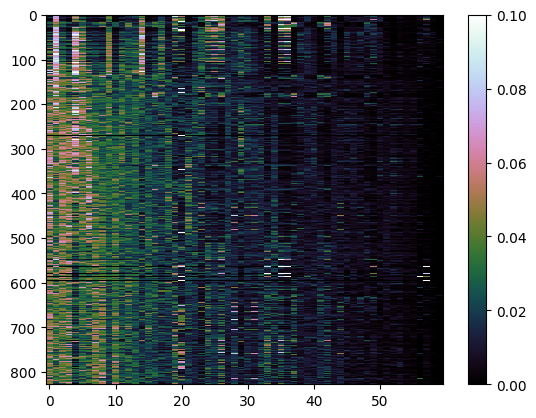

In [13]:
plt.imshow(usage_mtx, aspect='auto', interpolation='none', cmap='cubehelix', vmin=0, vmax=0.1)
plt.colorbar()

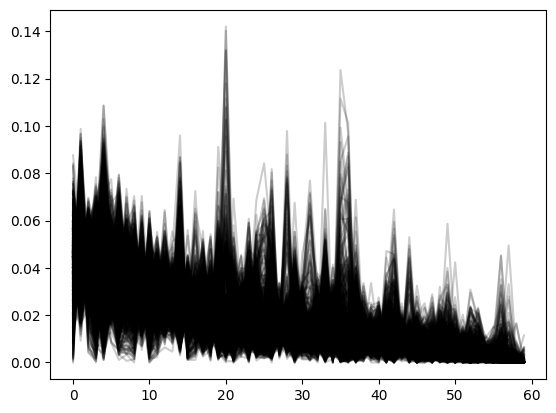

In [18]:
plt.plot(usage_mtx.values.T, c='k', alpha=0.2);

In [27]:
mdl = PLSRegression(n_components=5)
mdl.fit(usage_mtx, usage_mtx.index.get_level_values('age'))

PLSRegression(n_components=5)

In [20]:
age = usage_mtx.index.get_level_values('age')

In [28]:
r2_score(age, mdl.predict(usage_mtx).squeeze())

0.7436472989606429

In [29]:
projection = mdl.transform(usage_mtx)

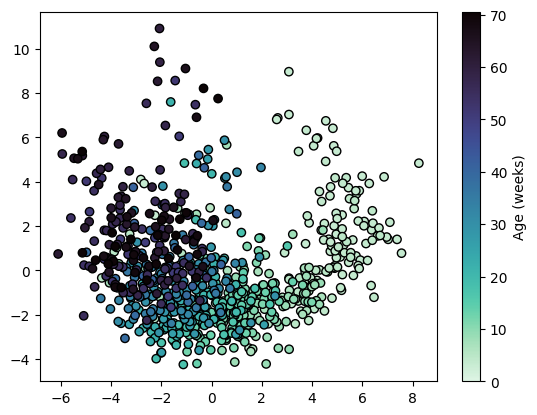

In [32]:
plt.scatter(projection[:, 0], projection[:, 1], c=usage_mtx.index.get_level_values('age'), cmap='mako_r', lw=1, edgecolors='k', vmin=0)
plt.colorbar(label='Age (weeks)')

In [41]:
ex = usage_mtx.loc[pd.IndexSlice[:, '01_02'], :]

In [42]:
mdl = PLSRegression(n_components=5)
mdl.fit(ex, ex.index.get_level_values('age'))

PLSRegression(n_components=5)

In [43]:
projection = mdl.transform(ex)

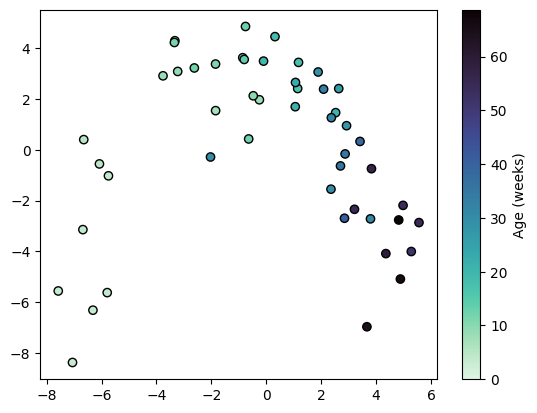

In [44]:
plt.scatter(projection[:, 0], projection[:, 1], c=ex.index.get_level_values('age'), cmap='mako_r', lw=1, edgecolors='k', vmin=0)
plt.colorbar(label='Age (weeks)')

In [75]:
def zscore(df):
    return (df - df.mean()) / df.std()

In [84]:
mdl = LinearDiscriminantAnalysis(n_components=2)
mdl.fit(np.log(usage_mtx + 1e-6).iloc[:, :30], usage_mtx.index.get_level_values('mouse_id'))
out = mdl.transform(np.log(usage_mtx + 1e-6).iloc[:, :30])

In [85]:
lbls = pd.factorize(usage_mtx.index.get_level_values('mouse_id'))[0]

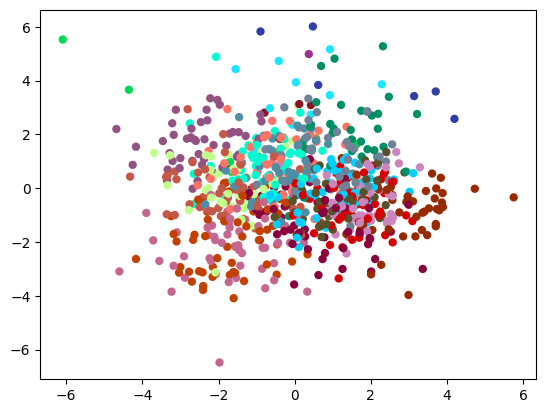

In [86]:
plt.scatter(out[:, 0], out[:, 1], c=lbls, cmap=cc.cm.glasbey, lw=0, edgecolors='k', vmin=0)
# plt.colorbar(label='Mouse ID')

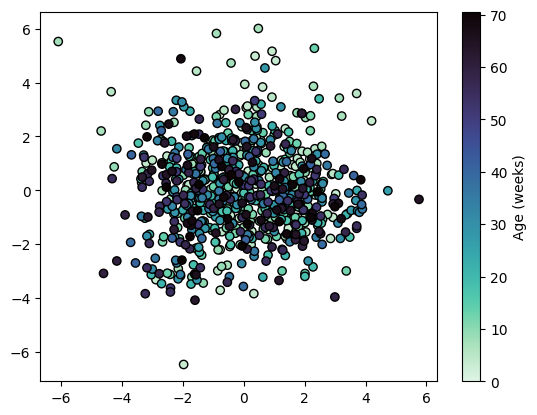

In [87]:
plt.scatter(out[:, 0], out[:, 1], c=usage_mtx.index.get_level_values('age'), cmap='mako_r', lw=1, edgecolors='k', vmin=0)
plt.colorbar(label='Age (weeks)')

In [ ]:
lbls = pd.factorize(usage_mtx.index.get_level_values('mouse_id'))[0]

In [126]:
mdl = umap.UMAP(n_components=2, n_neighbors=30, metric=jensenshannon, repulsion_strength=0.001, min_dist=1)

In [127]:
out = mdl.fit_transform(usage_mtx.to_numpy(), y=lbls)
# out = mdl.fit_transform(usage_mtx.to_numpy())

/Users/wingillis/miniconda3/envs/aging/lib/python3.10/site-packages/umap/umap_.py:1772: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


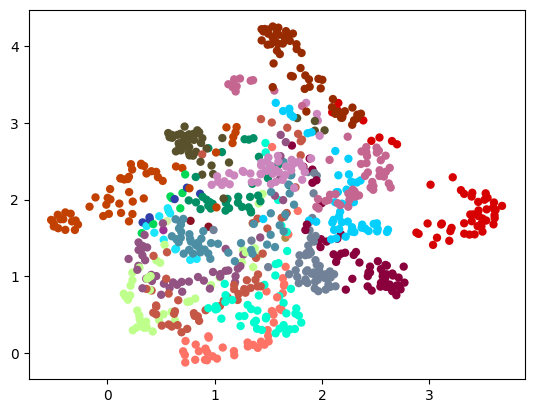

In [128]:
plt.scatter(out[:, 0], out[:, 1], c=lbls, cmap=cc.cm.glasbey, lw=0, edgecolors='k', vmin=0)
# plt.colorbar(label='Mouse ID')

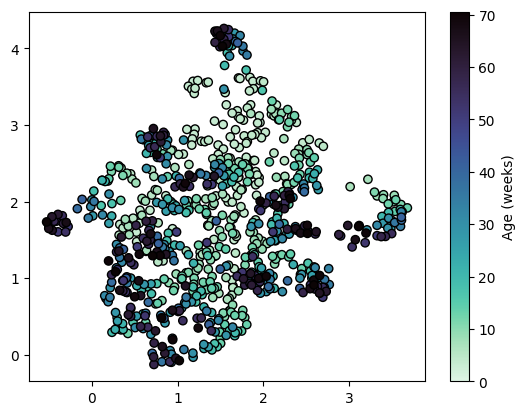

In [129]:
plt.scatter(out[:, 0], out[:, 1], c=usage_mtx.index.get_level_values('age'), cmap='mako_r', lw=1, edgecolors='k', vmin=0)
plt.colorbar(label='Age (weeks)')

## Try guided autoencoder

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F